In [1]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LSKmix= np.array(pd.read_csv ('../data/processed_data/LSKmix.csv'))
y = np.array(LSKmix[:,-1],dtype=int)
LSKmix= LSKmix[:,0:-1]


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSKmix,y)

In [5]:
print(LSKmix.shape, len(pred))
acc = model.score_
print(acc)

(1023, 7230) 1023
0.11730769230769231


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (122.0, 918.0, 0.1328976034858388, 0.29539951573849876, 0.9941638322896469, 0.11730769230769231, 0.9981425689994128, 0.8826923076923077, 0.7046004842615012)


# Mutual information maximizer (MIM)

test 0.27754506553354485 0.02986839534041332
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (148.0, 807.0, 0.18339529120198264, 0.26714801444043323, 0.9958914361645258, 0.1549738219895288, 0.9979287616443387, 0.8450261780104712, 0.7328519855595668)


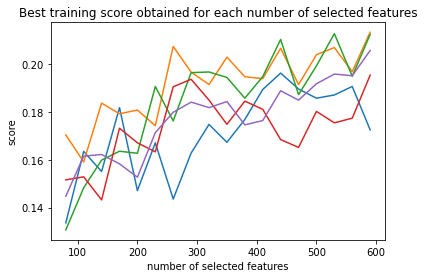

In [7]:
#Define parameters for MIM method
N = np.arange(80,600,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSKmix, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSKmix[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

test 0.2865741838827226 0.03986084244019426
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (168.0, 886.0, 0.18961625282167044, 0.3708609271523179, 0.993944902715226, 0.15939278937381404, 0.9980442211882901, 0.8406072106261859, 0.6291390728476821)


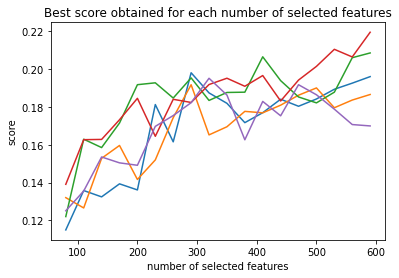

In [8]:
#Define parameters for ANOVA method
N = np.arange(80,600,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSKmix, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSKmix[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

# Without Cross-validation

In [7]:
libraries_LSKmix = ['Weinreb_LK_LSK_D2_exp3_library_d2_1_norm.rds', 'Weinreb_LK_LSK_D2_exp3_library_d2_2_norm.rds', 'Weinreb_LK_LSK_D2_exp3_library_d2_3_norm.rds', 'Weinreb_LK_LSK_D2_exp3_library_d2_4_norm.rds', 'Weinreb_LK_LSK_D2_exp3_library_d2_5_norm.rds', 
                    'Weinreb_LK_LSK_D2_exp3_library_d2_6_norm.rds']
family_info_LSKmix = ['family_info_Weinreb_LK_LSK_D2_exp3_library_d2_1.RData','family_info_Weinreb_LK_LSK_D2_exp3_library_d2_2.RData','family_info_Weinreb_LK_LSK_D2_exp3_library_d2_3.RData','family_info_Weinreb_LK_LSK_D2_exp3_library_d2_4.RData',
                      'family_info_Weinreb_LK_LSK_D2_exp3_library_d2_5.RData', 'family_info_Weinreb_LK_LSK_D2_exp3_library_d2_6.RData']

LSK_exp1_d2_1

In [39]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[0]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[0]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp1_d2_1genes_interest.csv', index=False)

LSK_exp1_d2_1 = np.array(norm).T
y = np.squeeze(np.array(y))

print(LSK_exp1_d2_1.shape, y.shape)

(114, 6056) (114,)


1525 0.9583333333333334


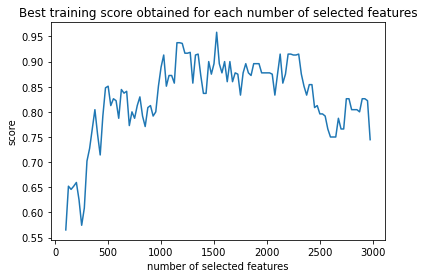

In [19]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp1_d2_1, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [20]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9583333333333334 0.8421052631578947
1.0 0.7192982456140351


In [21]:
MIM_sub = best_subset

In [22]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp1_d2_1genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_1genes_best1.csv')

1650 0.98


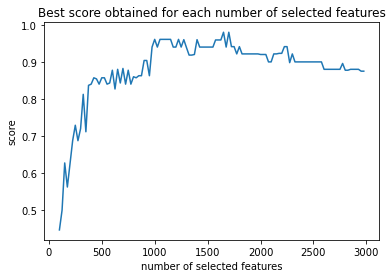

In [23]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_1, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [24]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.98 0.8771929824561403
0.9777777777777777 0.7894736842105263


1636 0.98


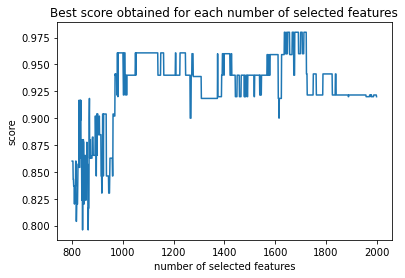

In [40]:
N = np.arange(800,2000,1)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_1, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [41]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.98 0.8771929824561403
0.9782608695652174 0.8070175438596491


In [25]:
ANOVA_sub = best_subset

In [26]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp1_d2_1genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_1genes_best2.csv')

LSK_exp1_d2_2

In [42]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[1]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[1]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp1_d2_2genes_interest.csv', index=False)

LSK_exp1_d2_2 = np.array(norm).T
y = np.squeeze(np.array(y))
print(LSK_exp1_d2_2.shape, y.shape)

(117, 7125) (117,)


1725 0.9166666666666666


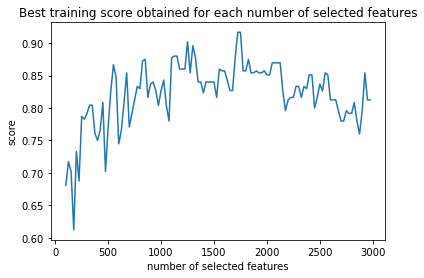

In [28]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp1_d2_2, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [29]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9166666666666666 0.8205128205128205
0.9761904761904762 0.717948717948718


In [30]:
MIM_sub = best_subset

In [31]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp1_d2_2genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_2genes_best1.csv')

1325 0.9807692307692307


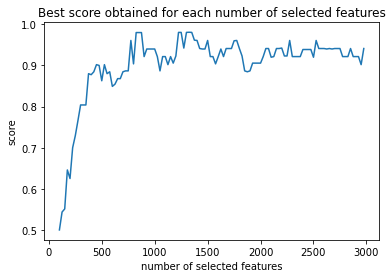

In [32]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_2, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [33]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9807692307692307 0.8888888888888888
0.98 0.8547008547008547


1289 0.9807692307692307


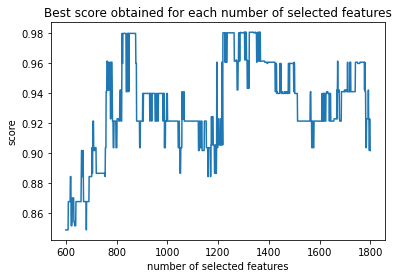

In [43]:
N = np.arange(600,1800,1)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_2, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [44]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9807692307692307 0.8888888888888888
1.0 0.8205128205128205


In [34]:
ANOVA_sub = best_subset

In [35]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp1_d2_2genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_2genes_best2.csv')

LSK_exp1_d2_3

In [86]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[2]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[2]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp1_d2_3genes_interest.csv', index=False)

LSK_exp1_d2_3 = np.array(norm).T
y = np.squeeze(np.array(y))

print(LSK_exp1_d2_3.shape, y.shape)

(133, 7024) (133,)


625 0.8653846153846154


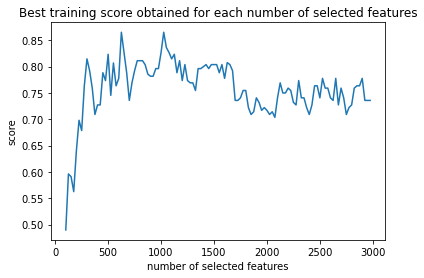

In [46]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp1_d2_3, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [49]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_3[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.8653846153846154 0.7819548872180451
0.925 0.6015037593984962


In [50]:
MIM_sub = best_subset

In [51]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp1_d2_3genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_3genes_best1.csv')

1125 0.9272727272727272


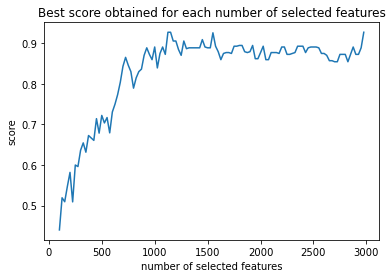

In [55]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_3, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [56]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_3[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9272727272727272 0.8270676691729323
0.9574468085106383 0.706766917293233


1139 0.9433962264150944


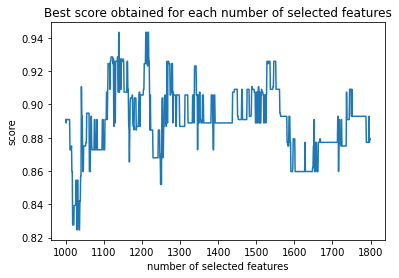

In [87]:
N = np.arange(1000,1800,1)
best_subset, best_score = ANOVA(y, LSK_exp1_d2_3, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [88]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp1_d2_3[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9433962264150944 0.7969924812030075
0.9375 0.7218045112781954


In [89]:
ANOVA_sub = best_subset

In [90]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp1_d2_3genes_interest.csv', '../data/optimized_subsets/LSKmix_exp1_d2_3genes_best2.csv')

LSK_exp2_d2B_4

In [92]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[3]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[3]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp2_d2B_4genes_interest.csv', index=False)

LSK_exp2_d2B_4 = np.array(norm).T
y = np.squeeze(np.array(y))

print(LSK_exp2_d2B_4.shape, y.shape)

(92, 6817) (92,)


750 0.95


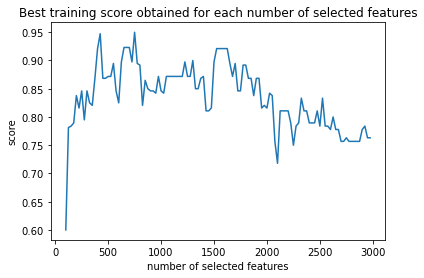

In [60]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp2_d2B_4, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [61]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_4[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.95 0.8695652173913043
0.9714285714285714 0.7608695652173914


In [62]:
MIM_sub = best_subset

In [63]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp2_d2B_4genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_4genes_best1.csv')

900 0.9767441860465116


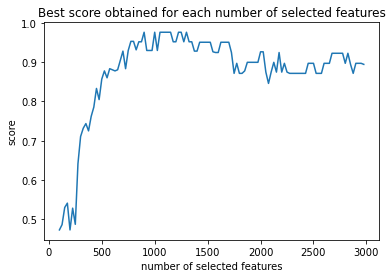

In [64]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_4, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [65]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_4[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9767441860465116 0.9347826086956522
0.975609756097561 0.8913043478260869


832 0.9772727272727273


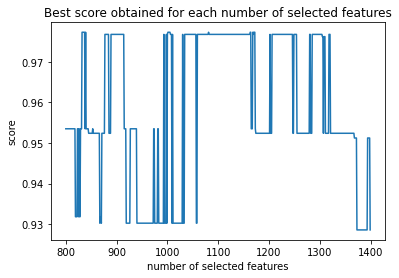

In [93]:
N = np.arange(800,1400,1)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_4, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [94]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_4[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9772727272727273 0.9565217391304348
0.9767441860465116 0.9347826086956522


In [95]:
ANOVA_sub = best_subset

In [96]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp2_d2B_4genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_4genes_best2.csv')

LSK_exp2_d2B_5

In [97]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[4]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[4]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp2_d2B_5genes_interest.csv', index=False)

LSK_exp2_d2B_5 = np.array(norm).T
y = np.squeeze(np.array(y))
print(LSK_exp2_d2B_5.shape, y.shape)

(122, 7032) (122,)


375 0.9148936170212766


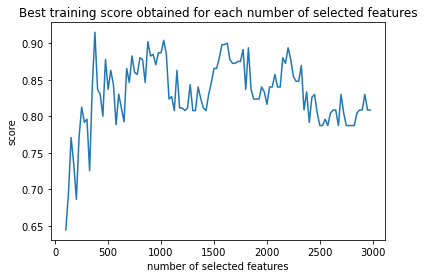

In [69]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [70]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9148936170212766 0.7704918032786885
0.926829268292683 0.6721311475409836


In [71]:
MIM_sub = best_subset

In [72]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp2_d2B_5genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_5genes_best1.csv')

1825 0.9433962264150944


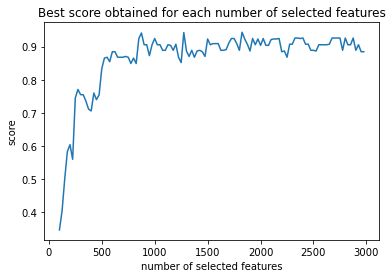

In [73]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [74]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9433962264150944 0.8688524590163934
0.98 0.819672131147541


1717 0.9622641509433962


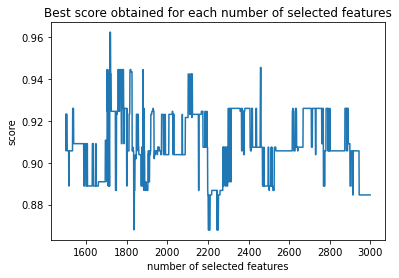

In [98]:
N = np.arange(1500,3000,1)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [99]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9622641509433962 0.8688524590163934
0.9591836734693877 0.8032786885245902


In [100]:
ANOVA_sub = best_subset

In [101]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp2_d2B_5genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_5genes_best2.csv')

LSK_exp2_d2B_6

In [102]:
#Load data
norm_path = '../data/family_datasets/Weinreb_libraries_norm_lifted/' +  libraries_LSKmix[5]
norm  = pyreadr.read_r(norm_path)
norm = norm[None]

family_info_path = '../data/family_datasets/Family_info/' + family_info_LSKmix[5]
family_info = pyreadr.read_r(family_info_path)
family_info = np.array(family_info['WORK_clones'])
family_info[:, [1, 0]] = family_info[:, [0, 1]]
    
families, count = np.unique(family_info[:,0], return_counts=True)
family_interest = families[np.logical_and(count > 1, count < 6)]

#Conversion into array 
family_interest = np.array(family_interest)
family_info = np.array(family_info) 

#Norm data with only the cells belonging to the family of interest
cells_interest = []
for fam in family_interest:
    cell = family_info[fam == family_info[:,0]][:,1]
    cells_interest.append(cell)
cells_interest = [item for sublist in cells_interest for item in sublist]
        
norm = norm.loc[:,cells_interest]
y = pd.DataFrame(np.zeros((norm.shape[1],)), index= norm.columns)
family_info = pd.DataFrame(family_info[:,0], index = family_info[:,1])
y.loc[cells_interest] = family_info.loc[cells_interest]

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(norm,0.05)
norm = norm[gene_expressed]

#Store the name of genes of interest
genes_interest = norm.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/LSKmix_exp2_d2B_6genes_interest.csv', index=False)

LSK_exp2_d2B_5 = np.array(norm).T
y = np.squeeze(np.array(y))
print(LSK_exp2_d2B_5.shape, y.shape)

(135, 7399) (135,)


1175 0.7916666666666666


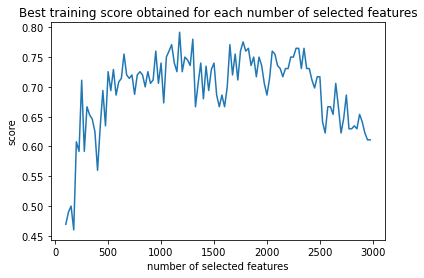

In [78]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [79]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.7916666666666666 0.7111111111111111
0.9473684210526315 0.562962962962963


In [80]:
MIM_sub = best_subset

In [81]:
get_best_genes_names(MIM_sub, '../data/processed_data/LSKmix_exp2_d2B_6genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_6genes_best1.csv')

725 0.8235294117647058


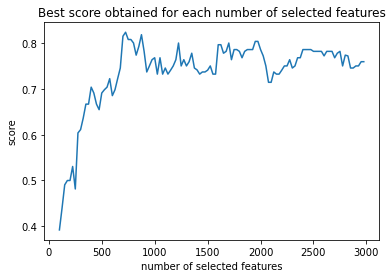

In [82]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [83]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.8235294117647058 0.7555555555555555
0.8636363636363636 0.6518518518518519


877 0.8363636363636363


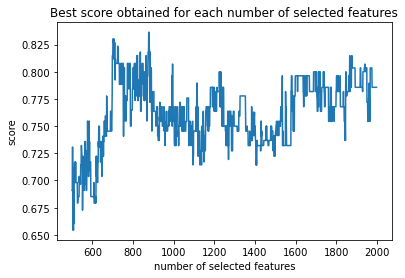

In [103]:
N = np.arange(500,2000,1)
best_subset, best_score = ANOVA(y, LSK_exp2_d2B_5, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [104]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK_exp2_d2B_5[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.8363636363636363 0.8148148148148148
0.8936170212765957 0.6962962962962963


In [105]:
ANOVA_sub = best_subset

In [106]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/LSKmix_exp2_d2B_6genes_interest.csv', '../data/optimized_subsets/LSKmix_exp2_d2B_6genes_best2.csv')